In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_sinewave, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle, get_ece
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
import timeit

### Visualize the data

<AxesSubplot: >

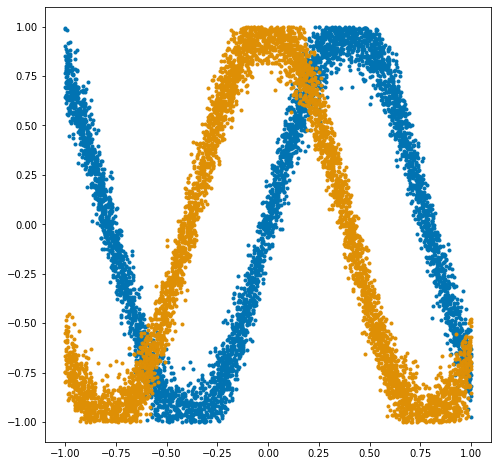

In [2]:
X, y = generate_sinewave(10000)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [4]:
# network architecture [1000, 1000, 1000, 1000, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Metal device set to: Apple M1 Max


2023-09-01 22:23:36.239055: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-01 22:23:36.239162: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-01 22:23:36.438052: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-01 22:23:36.634934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping


### Calculate posteriors and likelihoods using KDN

In [6]:
df = {}

t_0 = timeit.default_timer()
model_kdn = kdn(network=nn)
model_kdn.fit(X, y, k=1e9)
t_1 = timeit.default_timer()

print(f"Elapsed time: {t_1-t_0} s")
#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod = likelihoods_kdn_geod[:,1].reshape(400,400)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod'] = class1_likelihoods_geod
df['likelihood_class2_geod'] = class2_likelihoods_geod

Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.53s/it]


Elapsed time: 69.77729562500099 s
  73/5000 [..............................] - ETA: 10s

2023-09-01 22:25:48.363634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 10s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:39<00:00, 67.98s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:07<00:00, 61.59s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:19<00:00, 63.96s/it]


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:45<00:00, 81.04s/it]


In [7]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/sinewave_pdf.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[100:300, 100:300] = 1 - tmp

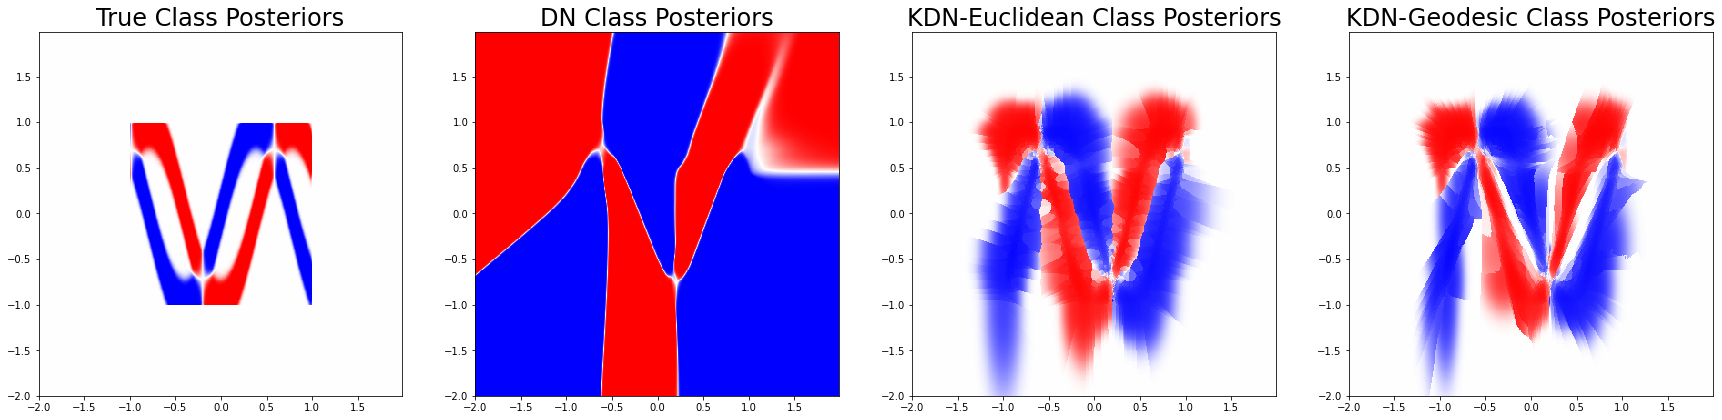

In [8]:
fig1, ax = plt.subplots(1, 4, figsize=(30, 150))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    1-posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    1-posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN-Euclidean Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    1-posterior_kdn_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDN-Geodesic Class Posteriors", fontsize=24)
ax[3].set_aspect("equal")
plt.show()

### Visualize class likelihoods

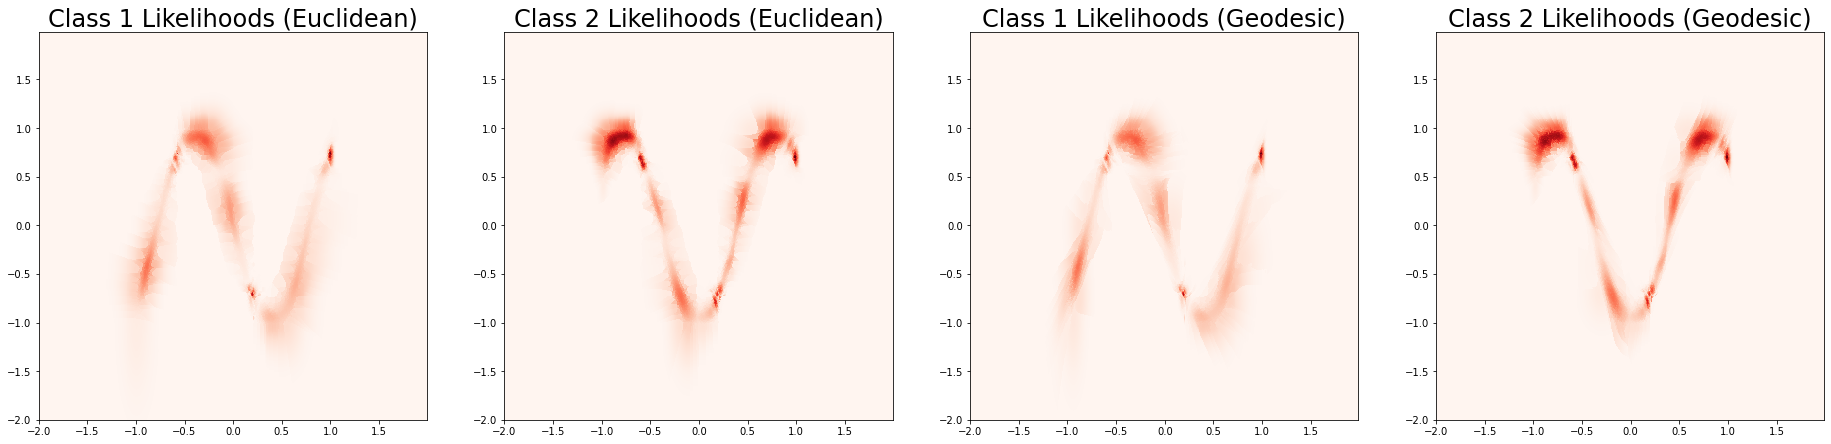

In [9]:
fig1, ax = plt.subplots(1, 4, figsize=(32, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods (Euclidean)", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods (Euclidean)", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    class1_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("Class 1 Likelihoods (Geodesic)", fontsize=24)
ax[2].set_aspect("equal")

ax3 = ax[3].imshow(
    class2_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("Class 2 Likelihoods (Geodesic)", fontsize=24)
ax[3].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [10]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/sinewave_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((true_posterior.ravel(), 1-true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_sinewave(sample)
    X_test, y_test = generate_sinewave(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e10)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)
    error_kdn_geod = 1 - np.mean(model_kdn.predict(X_test, distance='Geodesic')==y_test)
    error_dn = 1 - np.mean(np.argmax(model_kdn.network.predict(X_test),axis=1)==y_test)
    
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic')
    proba_dn = model_kdn.network.predict(grid_samples)
    
    hellinger_dis_kdn = hellinger(true_posterior, proba_kdn)
    hellinger_dis_kdn_geod = hellinger(true_posterior, proba_kdn_geod)
    hellinger_dis_dn = hellinger(true_posterior, proba_dn)
    
    
    return error_kdn, error_kdn_geod, error_dn, hellinger_dis_kdn, hellinger_dis_kdn_geod, hellinger_dis_dn

def experiment_out(in_sample, r, n_test):
    mmcOut_dn = np.zeros(len(r),dtype=float)
    mmcOut_kdn = np.zeros(len(r),dtype=float)
    mmcOut_kdn_geod = np.zeros(len(r),dtype=float)
    
    X, y = generate_sinewave(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e3)
    
    for ii, r_ in enumerate(r):
        X_ood = sample_unifrom_circle(n=n_test, r=r_)
        mmcOut_dn[ii] = np.mean(np.max(
            model_kdn.network.predict(X_ood), axis=1
            )
        )
        mmcOut_kdn[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
        mmcOut_kdn_geod[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood, distance='Geodesic'), axis=1))
    
    return mmcOut_kdn, mmcOut_kdn_geod, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_kdn_geod_med = []
error_kdn_geod_25 = []
error_kdn_geod_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_kdn_geod_med = []
hellinger_kdn_geod_25 = []
hellinger_kdn_geod_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []


mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_kdn_geod_med = []
mmcOut_kdn_geod_25 = []
mmcOut_kdn_geod_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []


#### do out-of-distribution results ####
r = np.arange(0,10.5,.5)
mmcOut_kdn = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_kdn_geod = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_dn = np.zeros((len(r),mc_reps), dtype=float)

for rep in range(mc_reps):
    mmcOut_kdn[:,rep], mmcOut_kdn_geod[:,rep], mmcOut_dn[:,rep] = experiment_out(1000, r, n_test)
    
    
mmcOut_kdn_med = np.median(mmcOut_kdn, axis=1)
mmcOut_kdn_25 = np.quantile(mmcOut_kdn, [0.25], axis=1)
mmcOut_kdn_75 = np.quantile(mmcOut_kdn, [0.75], axis=1)

mmcOut_kdn_geod_med = np.median(mmcOut_kdn_geod, axis=1)
mmcOut_kdn_geod_25 = np.quantile(mmcOut_kdn_geod, [0.25], axis=1)
mmcOut_kdn_geod_75 = np.quantile(mmcOut_kdn_geod, [0.75], axis=1)

mmcOut_dn_med = np.median(mmcOut_dn, axis=1)
mmcOut_dn_25 = np.quantile(mmcOut_dn, [0.25], axis=1)
mmcOut_dn_75 = np.quantile(mmcOut_dn, [0.75], axis=1)
    
        
#### do in-distribution results ####
for sample in sample_size:
    err_kdn = []
    err_kdn_geod = []
    err_dn = []
    hellinger_kdn = []
    hellinger_kdn_geod = []
    hellinger_dn = []
    
    for ii in range(mc_reps):
        a,b,c,d,e,f = experiment_in(sample, n_test, true_posterior) 
        
        err_kdn.append(a)
        err_kdn_geod.append(b)
        err_dn.append(c)
        hellinger_kdn.append(d)
        hellinger_kdn_geod.append(e)
        hellinger_dn.append(f)
        

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )
    
    error_kdn_geod_med.append(
        np.median(err_kdn_geod)
    )
    error_kdn_geod_25.append(
        np.quantile(err_kdn_geod, [0.25])[0]
    )
    error_kdn_geod_75.append(
        np.quantile(err_kdn_geod, [0.75])[0]
    )
    
    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )
    
    hellinger_kdn_geod_med.append(
        np.median(hellinger_kdn_geod)
    )
    hellinger_kdn_geod_25.append(
        np.quantile(hellinger_kdn_geod, [0.25])[0]
    )
    hellinger_kdn_geod_75.append(
        np.quantile(hellinger_kdn_geod, [0.75])[0]
    )
    
    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )
    
    

df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_kdn_geod_med'] = error_kdn_geod_med
df['error_kdn_geod_25'] = error_kdn_geod_25
df['error_kdn_geod_75'] = error_kdn_geod_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_kdn_geod_med'] = hellinger_kdn_geod_med
df['hellinger_kdn_geod_25'] = hellinger_kdn_geod_25
df['hellinger_kdn_geod_75'] = hellinger_kdn_geod_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25
df['mmcOut_kdn_75'] = mmcOut_kdn_75

df['mmcOut_kdn_geod_med'] = mmcOut_kdn_geod_med
df['mmcOut_kdn_geod_25'] = mmcOut_kdn_geod_25
df['mmcOut_kdn_geod_75'] = mmcOut_kdn_geod_75

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25
df['mmcOut_dn_75'] = mmcOut_dn_75

2023-09-01 22:49:19.149838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:49:26.009095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]
2023-09-01 22:49:44.833832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 119: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:49:58.919363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]
2023-09-01 22:50:17.460334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:50:23.968597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]
2023-09-01 22:50:42.482991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:50:50.676964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.67it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.50it/s]
2023-09-01 22:51:09.646762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 70: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:51:18.492621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.72it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]
2023-09-01 22:51:37.488805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:51:42.891384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.27it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.21it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.40it/s]
2023-09-01 22:52:01.780213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:52:08.761166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.65it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.23it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.87it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.49it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.37it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.15it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]
2023-09-01 22:52:27.949313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 57: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.43it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 22:52:35.591780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.66it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.16it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.22it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.32it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.48it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.46it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.52it/s]
2023-09-01 22:52:54.986390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:53:01.026002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.85it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.39it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]
2023-09-01 22:53:20.140640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 79: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:53:30.199044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.82it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.59it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]
2023-09-01 22:53:49.298007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 277.33it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.82it/s]
2023-09-01 22:53:51.518282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.84it/s]


1250/1250 [==============================] - 3s 2ms/step


2023-09-01 22:53:58.753181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 286.06it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.40it/s]

32/32 [==============================] - 0s 2ms/step



2023-09-01 22:54:01.203170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.77it/s]


1250/1250 [==============================] - 3s 2ms/step


2023-09-01 22:54:08.120276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 302.04it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 74.10it/s]
2023-09-01 22:54:10.224723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.69it/s]


1250/1250 [==============================] - 3s 2ms/step


2023-09-01 22:54:17.379432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 150: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 266.62it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 77.86it/s]
2023-09-01 22:54:19.092604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79it/s]


1250/1250 [==============================] - 3s 2ms/step


2023-09-01 22:54:25.996721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 247.78it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.52it/s]
2023-09-01 22:54:28.189765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.74it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:54:35.106290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 230.61it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.13it/s]
2023-09-01 22:54:37.236051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.78it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:54:44.105695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 257.83it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 69.87it/s]
2023-09-01 22:54:46.299122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79it/s]


1250/1250 [==============================] - 3s 2ms/step


2023-09-01 22:54:53.196232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 273.27it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 75.17it/s]
2023-09-01 22:54:55.327853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.66it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:55:02.199316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 259.31it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 72.04it/s]
2023-09-01 22:55:04.308087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.86it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:55:11.014275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.82it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.46it/s]
2023-09-01 22:55:13.152660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:55:19.905377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 146.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.06it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:55:21.687584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:55:29.511943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 95: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 139.59it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 47.22it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:55:31.562469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:55:39.457943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 140.99it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.61it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:55:41.560529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:55:49.758903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 148.46it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.08it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:55:51.276114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:55:59.093450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 110: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 146.25it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.18it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:56:01.437560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:56:09.303852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 93: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 144.23it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.37it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:56:11.408581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:56:19.361862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 70: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 134.97it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.67it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:56:21.163886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:56:29.001408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 140.59it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.98it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:56:30.870213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:56:38.851760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 145.51it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.76it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:56:40.403258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:56:48.296114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 104: early stopping
Calculating Geodesic...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 152.99it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.47it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 22:56:50.598423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:56:58.463846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.26it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]
2023-09-01 22:57:02.973665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:57:20.291008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.14it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.32it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 22:57:24.328984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:57:41.589198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.64it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 22:57:45.449336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.43s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:58:02.672907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.44it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s]
2023-09-01 22:58:06.607999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.48s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:58:24.162608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 73: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.79it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 22:58:29.859096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.44s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:58:47.445186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.32it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.54it/s]


32/32 [==============================] - 0s 2ms/step


2023-09-01 22:58:52.528769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.34s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:59:09.127617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 47: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.26it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.27it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 22:59:13.151609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.36s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:59:29.884275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.62it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 22:59:34.053532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.37s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 22:59:50.898203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.57it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.33it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 22:59:56.195839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:00:13.189478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.27it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s]
2023-09-01 23:00:16.231265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:00:32.742580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.57it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.63it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 23:00:39.350772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.72s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:01:08.031102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 23:01:16.838172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.49s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:01:44.378497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 23:01:55.710065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.61s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:02:23.843596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 23:02:29.796360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.65s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:02:58.117868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.77it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.47it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 23:03:04.125090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.67s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:03:32.518806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 63: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.98it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 23:03:41.655888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.52s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:04:09.623404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 23:04:16.472851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.41s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:04:43.483900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.80it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 23:04:50.033075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.49s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:05:17.462391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.78it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 23:05:24.368502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.53s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:05:52.019686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 23:05:59.631038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.52s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:06:27.184033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.86s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]

 1/32 [..............................] - ETA: 2s


2023-09-01 23:07:09.121604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.47s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:09:32.519664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.10s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.52it/s]
2023-09-01 23:10:28.775298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.27s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:12:55.968675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.94s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 23:13:44.411938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.35s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:16:12.258109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.08s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 23:17:03.854635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.96s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:19:39.746871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.95s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.43it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 23:20:37.085392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.31s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:23:04.552675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.92s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.51it/s]

 1/32 [..............................] - ETA: 2s


2023-09-01 23:23:53.315292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.07s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:26:19.631255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.93s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 23:26:55.210372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:31<00:00, 30.33s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:29:33.361612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.94s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]

 1/32 [..............................] - ETA: 2s


2023-09-01 23:30:21.465829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.19s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:32:53.459984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.96s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.49it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 23:33:39.346953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.69s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:36:08.877398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.93s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.50it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 23:37:05.025102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.10s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:39:31.644387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 61: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.51s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]


32/32 [==============================] - 0s 3ms/step


2023-09-01 23:41:53.567203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:50<00:00, 82.12s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:48:51.289972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 84: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.82s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.38s/it]

22/32 [===================>..........] - ETA: 0s


2023-09-01 23:51:38.752189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:09<00:00, 73.83s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 23:57:55.395243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 82: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.08s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


25/32 [======================>.......] - ETA: 0s

2023-09-02 00:00:44.125305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:39<00:00, 79.96s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 00:07:31.261624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.68s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


24/32 [=====================>........] - ETA: 0s

2023-09-02 00:09:44.142760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:06<00:00, 73.25s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 00:15:57.625032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.20s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.38s/it]

27/32 [========================>.....] - ETA: 0s


2023-09-02 00:18:33.606076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:52<00:00, 82.44s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 00:25:33.004834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 61: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.47s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.39s/it]

24/32 [=====================>........] - ETA: 0s


2023-09-02 00:27:54.934424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:22<00:00, 76.51s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 00:34:24.576622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.07s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]
2023-09-02 00:36:30.463033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:36<00:00, 79.22s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 00:43:13.845155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.34s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]


26/32 [=======================>......] - ETA: 0s

2023-09-02 00:45:21.961017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:47<00:00, 81.52s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 00:52:17.118145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 84: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.80s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


 1/32 [..............................] - ETA: 2s

2023-09-02 00:55:06.410373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:00<00:00, 84.07s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-02 01:02:15.369702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 79: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:03<00:00, 12.60s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


22/32 [===================>..........] - ETA: 0s

2023-09-02 01:04:59.998457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:17<00:00, 75.42s/it]


1250/1250 [==============================] - 2s 2ms/step


### Save the result

In [11]:
import pickle
filename = 'results/sinewave.pickle'

with open(filename, 'wb') as f:
    pickle.dump(df,f)

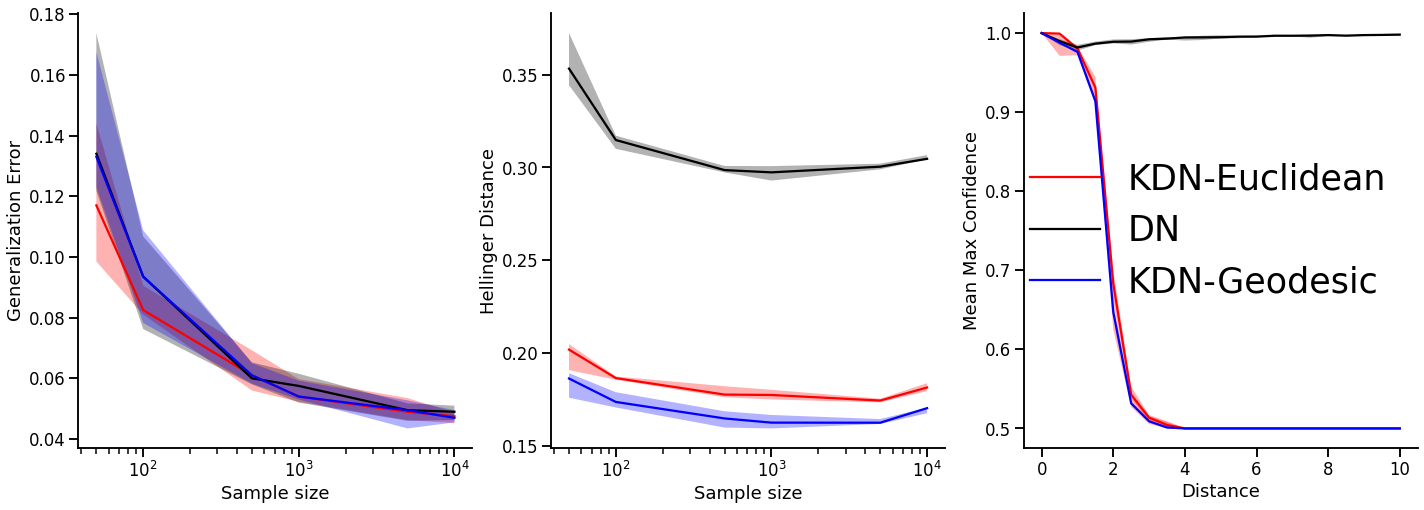

In [12]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,3, figsize=(24,8))


ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN-Euclidean')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')
ax[0].plot(sample_size, df['error_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)
ax[0].fill_between(sample_size, df['error_kdn_geod_25'], df['error_kdn_geod_75'], facecolor='b', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN-Euclidean')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')
ax[1].plot(sample_size, df['hellinger_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_kdn_geod_25'], df['hellinger_kdn_geod_75'], facecolor='b', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[2].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN-Euclidean')
ax[2].plot(r, df['mmcOut_dn_med'], c="k", label='DN')
ax[2].plot(r, df['mmcOut_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[2].fill_between(r, df['mmcOut_kdn_25'].ravel(), df['mmcOut_kdn_75'].ravel(), facecolor='r', alpha=.3)
ax[2].fill_between(r, df['mmcOut_dn_25'].ravel(), df['mmcOut_dn_75'].ravel(), facecolor='k', alpha=.3)
ax[2].fill_between(r, df['mmcOut_kdn_geod_25'].ravel(), df['mmcOut_kdn_geod_75'].ravel(), facecolor='r', alpha=.3)

#ax[3].set_xscale('log')
ax[2].set_xlabel('Distance')
ax[2].set_ylabel('Mean Max Confidence')

ax[2].legend(fontsize=35, frameon=False)

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)